In [0]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 30 22:15:05 2019

@author: Nolan
"""

import pickle
import glob
from random import shuffle
import numpy as np
import torch
from torch.utils import data

import matplotlib.pyplot as plt

import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

from tqdm import tqdm

from scipy import signal
from scipy.io import wavfile


import torch
import torch.nn as nn

filelist=[]
labels=[]



from torch.utils import data
from scipy.io import wavfile
import numpy as np
from scipy import signal


class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs


  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
        #return 100

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        rate,data=wavfile.read(ID)
        frequencies, times, spectrogram = signal.spectrogram(data,rate)
        spec=np.float32(np.interp(spectrogram,(spectrogram.min(),spectrogram.max()),(-1,+1)))
        
        spec_zeros = np.float32(np.zeros((len(spec),100-len(spec[0]))))
        spec_out=np.concatenate((spec,spec_zeros),axis=1)
        X = spec_out
        y = self.labels[ID]
        return X, y

class ConvNetwork(nn.Module):
  def __init__(self):
    super(ConvNetwork,self).__init__()
    c=1
    out = 10
    Conv2d=nn.Conv2d
    self.net = nn.Sequential(
        Conv2d(c,32,(3,3),padding=(1,1)),
        nn.ReLU(),
        
        Conv2d(32,32,(3,3),padding=(1,1)),        
        nn.ReLU(),
        
             
        Conv2d(32,64,(3,3),padding=(1,1)),        
        nn.ReLU(),
        
        Conv2d(64,64,(3,3),padding=(1,1)),        
        nn.ReLU(),

        Conv2d(64,64,(129,100),padding=(0,0)),        
        nn.ReLU(),

        Conv2d(64,out,(1,1), padding=(0,0)),
    )
    
  def forward(self,x):
    return self.net(x).squeeze(2).squeeze(2)

  
import os
cwd = os.getcwd()
print(cwd)
  
import urllib.request
import os.path
from os import path
import tarfile
url='https://nolans-cs-bucket.s3-us-west-1.amazonaws.com/recordings.tar.gz'
location = './recordings.tar.gz'
if path.exists(location):
    print('already downloaded!')
else:
    urllib.request.urlretrieve(url,location)

location2='./filename.pickle'
if path.exists(location2):
    print('extracted!')
else:
    datas=tarfile.open(location)
    datas.extractall()
    datas.close()


with open(location2, 'rb') as handle:
    unserialized_data = pickle.load(handle)
    
t_labels=unserialized_data['t_labels']
training=unserialized_data['train']
v_labels=unserialized_data['v_labels']
validation=unserialized_data['validation']


validation_list=zip(validation,v_labels)
training_list=zip(training,t_labels)

validation_dict=dict(list(validation_list))
training_dict=dict(list(training_list))


partition = {'train':training,'validation':validation}


params={'batch_size':100,'shuffle':True}
training_set=Dataset(partition['train'],training_dict)
training_generator=data.DataLoader(training_set,**params)

validation_set=Dataset(partition['validation'],validation_dict)
validation_generator=data.DataLoader(validation_set,**params)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epochs=200
#define the objective function
objective = torch.nn.CrossEntropyLoss()
model = ConvNetwork()
model.cuda()
#define the optimizer
optimizer = optim.Adam(model.parameters(),lr=1e-4)
losses=[]
losses_v=[]
accuracy_v=[]


   
    
for epoch in range(epochs):
    loop = tqdm(total=len(training_generator), position = 0)
    for batch in training_generator:
        x=torch.tensor((batch[0]))
        y_truth=[]
        for items in batch[1]:
            y_truth.append(int(items))
        y_truth=torch.tensor(y_truth)
        #print(y_truth)
        optimizer.zero_grad()
        x.unsqueeze_(1)
        x=x.cuda()
        y_truth=y_truth.cuda()
        y_hat=model(x)
        loss=objective(y_hat,y_truth)
        loss.backward()
        optimizer.step()
        y_truth
        losses.append(loss.item())
        loop.update(1)
    loop.set_description('loss:{:.4f}'.format(loss.item()))    
    for batch_v in validation_generator:
        with torch.no_grad():
            x_v=torch.tensor((batch_v[0]))
            y_truth=[]
            for items in batch_v[1]:
                y_truth.append(int(items))
            y_truth_v=torch.tensor(y_truth)
            x_v.unsqueeze_(1)
            x_v=x_v.cuda()
            
            y_truth_v=y_truth_v.cuda()
            y_hat_v=model(x_v)
            y_hot=torch.argmax(y_hat_v,dim=1)
            diff=y_hot-y_truth_v
            length_diff=diff.size(0)
            accuracy=(length_diff-np.count_nonzero(diff.cpu()))/length_diff

            loss_v=objective(y_hat_v,y_truth_v)
            
    losses_v.append(loss_v.item())
    accuracy_v.append(accuracy)
    print('validation loss: ' + str(loss_v.item()),'accuracy: ' + str(accuracy))

    with open('/content/drive/My Drive/model', 'w') as f:
      out=torch.save(model,'/content/drive/My Drive/model')




fig=plt.figure()
ax=fig.add_subplot(1,2,1)    
plt.plot(losses_v)
ax2=fig.add_subplot(1,2,2)  
plt.plot(losses)
ax2.set_yscale('log')
#temp=np.asarray(x[0][0])
#sd.play(temp,8000)
#y_truth_v[0]
#y_hat_v[0]

#samples=temp
#sample_rate=8000
#frequencies, times, spectrogram = signal.spectrogram(samples,sample_rate)

#plt.pcolormesh(times, frequencies, spectrogram)
#plt.imshow(spectrogram)
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
already downloaded!
extracted!


loss:2.3294: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss: 2.345473527908325 accuracy: 0.0


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
loss:2.2203: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 2.214857578277588 accuracy: 0.1


loss:2.1708: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 2.2599997520446777 accuracy: 0.3


loss:2.1133: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 2.0449745655059814 accuracy: 0.23333333333333334


loss:1.9016: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 2.048537492752075 accuracy: 0.4


loss:1.6373: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 1.575593113899231 accuracy: 0.5


loss:1.3753: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 1.3154815435409546 accuracy: 0.4666666666666667


loss:1.3436: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 1.2199552059173584 accuracy: 0.6333333333333333


loss:0.9754: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 1.070553183555603 accuracy: 0.6333333333333333


loss:1.0324: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 1.1796901226043701 accuracy: 0.5666666666666667


loss:0.7607: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.913237988948822 accuracy: 0.7


loss:0.7155: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.7699424028396606 accuracy: 0.7666666666666667


loss:0.9759: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.7794226408004761 accuracy: 0.7


loss:0.6506: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 1.0107364654541016 accuracy: 0.5666666666666667


loss:0.5117: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.7647702693939209 accuracy: 0.7666666666666667


loss:0.5930: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 1.2250772714614868 accuracy: 0.6


loss:0.5341: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.8069966435432434 accuracy: 0.7


loss:0.5712: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 1.2468950748443604 accuracy: 0.6333333333333333


loss:0.4717: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.36218249797821045 accuracy: 0.8333333333333334


loss:0.4606: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.4010483920574188 accuracy: 0.8666666666666667


loss:0.5451: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5736281871795654 accuracy: 0.8333333333333334


loss:0.3543: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.4934650659561157 accuracy: 0.8333333333333334


loss:0.2889: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5534278750419617 accuracy: 0.8333333333333334


loss:0.4161: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.8103011250495911 accuracy: 0.8


loss:0.2474: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5105552077293396 accuracy: 0.7666666666666667


loss:0.3289: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.32531681656837463 accuracy: 0.9


loss:0.2777: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5391772985458374 accuracy: 0.7666666666666667


loss:0.4101: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.8124411702156067 accuracy: 0.9


loss:0.3234: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.4933801293373108 accuracy: 0.7666666666666667


loss:0.2725: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.4726000726222992 accuracy: 0.7666666666666667


loss:0.3307: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.43375730514526367 accuracy: 0.8666666666666667


loss:0.2775: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.5967167019844055 accuracy: 0.8666666666666667


loss:0.3274: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.7498580813407898 accuracy: 0.7666666666666667


loss:0.1655: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.24458885192871094 accuracy: 0.9


loss:0.2680: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.5389242172241211 accuracy: 0.8


loss:0.2031: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.5068426728248596 accuracy: 0.8


loss:0.1560: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.25050416588783264 accuracy: 0.8666666666666667


loss:0.2224: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.4998074471950531 accuracy: 0.8


loss:0.1399: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.3761920630931854 accuracy: 0.8666666666666667


loss:0.4046: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.13780085742473602 accuracy: 0.9666666666666667


loss:0.1457: 100%|██████████| 17/17 [00:16<00:00,  1.09it/s]

validation loss: 0.5748570561408997 accuracy: 0.7666666666666667


loss:0.1662: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.8614723682403564 accuracy: 0.9


loss:0.2306: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.19502903521060944 accuracy: 0.9333333333333333


loss:0.0942: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.33621272444725037 accuracy: 0.9


loss:0.1137: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5210825204849243 accuracy: 0.8


loss:0.2606: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.4146527945995331 accuracy: 0.8666666666666667


loss:0.2429: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.7768901586532593 accuracy: 0.9333333333333333


loss:0.0926: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.8198134303092957 accuracy: 0.9333333333333333


loss:0.1653: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.16149534285068512 accuracy: 0.9333333333333333


loss:0.0440: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.25604864954948425 accuracy: 0.8666666666666667


loss:0.1975: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.3542573153972626 accuracy: 0.8333333333333334


loss:0.1326: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 1.0147252082824707 accuracy: 0.8333333333333334


loss:0.1567: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.9098823666572571 accuracy: 0.8666666666666667


loss:0.1060: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.21848580241203308 accuracy: 0.8666666666666667


loss:0.2699: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.1958545744419098 accuracy: 0.9333333333333333


loss:0.1856: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.18492616713047028 accuracy: 0.9666666666666667


loss:0.1787: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.20012174546718597 accuracy: 0.9


loss:0.2056: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.4924250543117523 accuracy: 0.9


loss:0.0238: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.05399741977453232 accuracy: 1.0


loss:0.0725: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 1.082397699356079 accuracy: 0.8666666666666667


loss:0.1587: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.40063604712486267 accuracy: 0.8666666666666667


loss:0.0739: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.10901571810245514 accuracy: 0.9666666666666667


loss:0.0359: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.07872588187456131 accuracy: 1.0


loss:0.1370: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.20388692617416382 accuracy: 0.9


loss:0.0536: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.13447946310043335 accuracy: 0.9666666666666667


loss:0.0576: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.30247238278388977 accuracy: 0.9


loss:0.0882: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]

validation loss: 0.6807043552398682 accuracy: 0.8666666666666667


loss:0.0722: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.7676258087158203 accuracy: 0.8


loss:0.0403: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.2767409086227417 accuracy: 0.9


loss:0.1301: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.515640377998352 accuracy: 0.8666666666666667


loss:0.0404: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.4513435959815979 accuracy: 0.8666666666666667


loss:0.0565: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.18716736137866974 accuracy: 0.9666666666666667


loss:0.0411: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.5963858962059021 accuracy: 0.8666666666666667


loss:0.1664: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]

validation loss: 1.1054120063781738 accuracy: 0.9


loss:0.0795: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.2311016023159027 accuracy: 0.8666666666666667


loss:0.0995: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.3079501986503601 accuracy: 0.8333333333333334


loss:0.0284: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.24038836359977722 accuracy: 0.9


loss:0.0149: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5418494343757629 accuracy: 0.9


loss:0.0199: 100%|██████████| 17/17 [00:16<00:00,  1.10it/s]

validation loss: 0.14504966139793396 accuracy: 0.9333333333333333


loss:0.1430: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.5221401453018188 accuracy: 0.8


loss:0.1875: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.22213885188102722 accuracy: 0.9


loss:0.1065: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.09398428350687027 accuracy: 0.9666666666666667


loss:0.0457: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.2619205415248871 accuracy: 0.9


loss:0.1769: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.3931693434715271 accuracy: 0.9333333333333333


loss:0.0314: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 1.747840404510498 accuracy: 0.7666666666666667


loss:0.0439: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.4148629605770111 accuracy: 0.9333333333333333


loss:0.0402: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.32581913471221924 accuracy: 0.9333333333333333


loss:0.0478: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 1.1906566619873047 accuracy: 0.9666666666666667


loss:0.0991: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.5276031494140625 accuracy: 0.8333333333333334


loss:0.0261: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.14238014817237854 accuracy: 0.9


loss:0.0567: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.7541617155075073 accuracy: 0.8666666666666667


loss:0.0196: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.44326165318489075 accuracy: 0.9333333333333333


loss:0.0998: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.49389299750328064 accuracy: 0.7666666666666667


loss:0.0508: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.3428887128829956 accuracy: 0.9


loss:0.0376: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.3367713987827301 accuracy: 0.8333333333333334


loss:0.0694: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.0166714359074831 accuracy: 1.0


loss:0.0859: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.11286570131778717 accuracy: 0.9666666666666667


loss:0.0230: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.0888165757060051 accuracy: 0.9666666666666667


loss:0.0408: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 1.5616295337677002 accuracy: 0.9


loss:0.1043: 100%|██████████| 17/17 [00:15<00:00,  1.14it/s]

validation loss: 0.2520536482334137 accuracy: 0.9666666666666667


loss:0.0339: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.23321112990379333 accuracy: 0.9333333333333333


loss:0.1192: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 1.335472583770752 accuracy: 0.8333333333333334


loss:0.0091: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.40563011169433594 accuracy: 0.9333333333333333


loss:0.1791: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.40552788972854614 accuracy: 0.9


loss:0.0252: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.18448257446289062 accuracy: 0.9333333333333333


loss:0.0728: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.8478332161903381 accuracy: 0.7666666666666667


loss:0.0457: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.23852334916591644 accuracy: 0.9


loss:0.0649: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.46136951446533203 accuracy: 0.9333333333333333


loss:0.0680: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.27196043729782104 accuracy: 0.8666666666666667


loss:0.1519: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.430973619222641 accuracy: 0.8666666666666667


loss:0.0738: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]

validation loss: 0.49192294478416443 accuracy: 0.8333333333333334


loss:0.0726: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.45481693744659424 accuracy: 0.8666666666666667


loss:0.0772: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.4532780349254608 accuracy: 0.8333333333333334


loss:0.0909: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 1.2189449071884155 accuracy: 0.8666666666666667


loss:0.0276: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]

validation loss: 0.19260533154010773 accuracy: 0.9666666666666667


loss:0.0616: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.23163528740406036 accuracy: 0.8666666666666667


loss:0.1114: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.028767459094524384 accuracy: 1.0


loss:0.0383: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.33785566687583923 accuracy: 0.9333333333333333


loss:0.0372: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.6124041676521301 accuracy: 0.8666666666666667


loss:0.0458: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.22916539013385773 accuracy: 0.9333333333333333


loss:0.0687: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.15748220682144165 accuracy: 0.9333333333333333


loss:0.0447: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.44526317715644836 accuracy: 0.8


loss:0.0453: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.06883837282657623 accuracy: 0.9666666666666667


loss:0.0738: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.22398929297924042 accuracy: 0.9333333333333333


loss:0.0129: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.009950383566319942 accuracy: 1.0


loss:0.0286: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.9186755418777466 accuracy: 0.8


loss:0.0615: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 0.008199374191462994 accuracy: 1.0


loss:0.0030: 100%|██████████| 17/17 [00:16<00:00,  1.13it/s]

validation loss: 0.47518107295036316 accuracy: 0.8333333333333334


loss:0.0080: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.1696547120809555 accuracy: 0.9666666666666667


loss:0.0128: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.8210023641586304 accuracy: 0.8


loss:0.0075: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 1.769375205039978 accuracy: 0.8666666666666667


loss:0.0341: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.5112912654876709 accuracy: 0.8333333333333334


loss:0.0244: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.01626790314912796 accuracy: 1.0


loss:0.0666: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.24421259760856628 accuracy: 0.9


loss:0.0061: 100%|██████████| 17/17 [00:16<00:00,  1.11it/s]

validation loss: 2.1413538455963135 accuracy: 0.8333333333333334


loss:0.0826: 100%|██████████| 17/17 [00:16<00:00,  1.12it/s]

validation loss: 0.4556807279586792 accuracy: 0.8333333333333334


loss:0.0087: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]

validation loss: 0.38081663846969604 accuracy: 0.9333333333333333


loss:0.0147: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]

validation loss: 0.5461708903312683 accuracy: 0.8666666666666667


loss:0.0368: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]

validation loss: 0.19389642775058746 accuracy: 0.9333333333333333


 18%|█▊        | 3/17 [00:02<00:13,  1.04it/s]

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Accuracy')

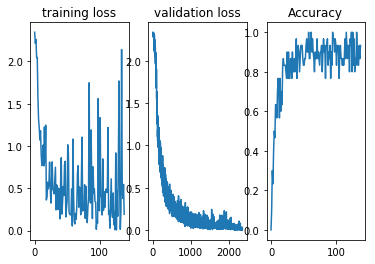

In [0]:
fig=plt.figure()
ax=fig.add_subplot(1,3,1)   
plt.title('training loss')
plt.plot(losses_v)
ax2=fig.add_subplot(1,3,2)  
plt.plot(losses)
plt.title('validation loss')
ax2=fig.add_subplot(1,3,3)  
plt.plot(accuracy_v)
plt.title('Accuracy')

